In [ ]:
import numpy as np
from scipy.interpolate import BSpline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

X = X.astype(np.float32) / 255.0

y = np.array(y).astype(np.int64)
y = y.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False, categories='auto')
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000, 10), (14000, 10))

In [ ]:
len(X_train)

56000

In [ ]:
class KAN:
  def __init__(self, input_dim, output_dim, num_hidden, num_bsplines, degree):
    self.W1 = np.random.randn(input_dim, num_hidden) * 0.01
    self.b1 = np.zeros((1, num_hidden))

    self.W2 = np.random.randn(num_hidden, output_dim) * 0.01
    self.b2 = np.zeros((1, output_dim))

    self.degree = degree
    self.num_bsplines = num_bsplines
    self.num_knots = num_bsplines + degree + 1
    self.knots = np.linspace(0, 1, self.num_knots)
    self.control_points = np.random.randn(num_hidden, num_bsplines)

  def softmax(self, x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

  def forward(self, X):
    self.z1 = np.dot(X, self.W1) + self.b1 # (m, num_hidden)

    self.basis = []
    for i in range(self.num_bsplines):
      c = np.zeros(self.num_bsplines)
      c[i] = 1
      self.basis.append(BSpline(self.knots, c, self.degree))

    self.basis = np.stack([bspline(self.z1) for bspline in self.basis], axis=-1) # (batch_size, num_hidden, num_bsplines)
    self.a1 = np.einsum('ijk,jk->ij', self.basis, self.control_points) # (batch_size, num_hidden)

    self.z2 = np.dot(self.a1, self.W2) + self.b2 # (batch_size, output_dim)
    self.a2 = self.softmax(self.z2) # (batch_size, output_dim)

    return self.a2

  def backward(self, x, y, lr, batch_size):
    dz2 = (self.a2 - y) / batch_size # (batch_size, output_dim)
    dW2 = np.dot(self.a1.T, dz2) # (num_hidden, output_dim)
    db2 = np.sum(dz2, axis=0, keepdims=True) # (1, output_dim)

    da1 = np.dot(dz2, self.W2.T) # (batch_size, num_hidden)
    dcontrol_points = np.einsum('ijk,ij->jk', self.basis, da1)  # (num_hidden, num_bsplines)
    dW1 = np.dot(x.T, da1) # (input_dim, num_hidden)
    db1 = np.sum(da1, axis=0, keepdims=True) # (1, num_hidden)

    self.W1 -= lr * dW1
    self.b1 -= lr * db1
    self.control_points -= lr * dcontrol_points
    self.W2 -= lr * dW2
    self.b2 -= lr * db2

  def cross_entropy(self, y_pred, y_true):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

  def accuracy(self, y_pred, y_true):
    pred = np.argmax(y_pred, axis=1)
    true = np.argmax(y_true, axis=1)
    return np.mean(pred == true)

  def train(self, X, y, batch_size=32, epochs=10, lr=0.001):
    for epoch in range(epochs):
      total_loss = 0
      correct_pred = 0

      for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        pred = self.forward(x_batch)
        loss = self.cross_entropy(pred, y_batch)
        total_loss += loss

        batch_accuracy = self.accuracy(pred, y_batch)
        correct_pred += batch_accuracy * len(x_batch)

        self.backward(x_batch, y_batch, lr, batch_size)

      total_loss = total_loss / len(X)
      total_accuracy = (correct_pred / len(X)) * 100
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {total_accuracy:.4f}")


In [ ]:
model = KAN(784, 10, 128, 16, 3)

In [ ]:
model.train(X_train, y_train, batch_size=32, epochs=10, lr=0.001)

Epoch 1/10, Loss: 0.2150, Accuracy: 75.0036
Epoch 2/10, Loss: 0.0921, Accuracy: 84.5393
Epoch 3/10, Loss: 0.0552, Accuracy: 85.7196
Epoch 4/10, Loss: 0.0409, Accuracy: 86.0018
Epoch 5/10, Loss: 0.0263, Accuracy: 87.2179
Epoch 6/10, Loss: 0.0211, Accuracy: 87.3268
Epoch 7/10, Loss: 0.0181, Accuracy: 87.6661
Epoch 8/10, Loss: 0.0202, Accuracy: 86.6911
Epoch 9/10, Loss: 0.0402, Accuracy: 85.4732
Epoch 10/10, Loss: 0.0140, Accuracy: 89.6500


In [ ]:
y_test_pred = model.forward(X_test)

In [ ]:
y_pred_classes = np.argmax(y_test_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Accuracy: 89.8714%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1343
           1       0.97      0.95      0.96      1600
           2       0.89      0.89      0.89      1380
           3       0.90      0.86      0.88      1433
           4       0.94      0.87      0.90      1295
           5       0.78      0.90      0.83      1273
           6       0.91      0.97      0.94      1396
           7       0.91      0.92      0.91      1503
           8       0.86      0.83      0.84      1357
           9       0.89      0.86      0.87      1420

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



<Axes: >

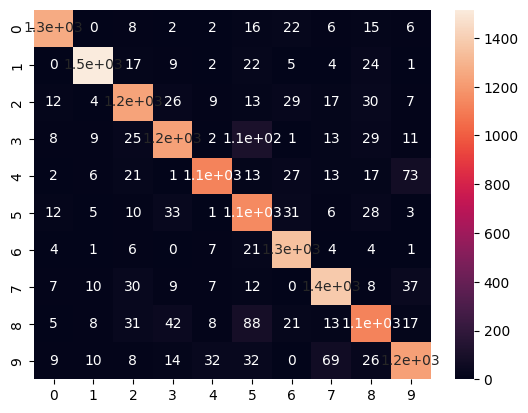

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.4f}%")

class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True)
# print(conf_matrix)